# Waterloo Takeoff Data Source Code

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np

### File Readings and Dataframe Creation

In [38]:
%%time
# Flights from Apr 16 to May 23

subfolders = [f.path for f in os.scandir('data/waterloo/flight/') if f.is_dir()]
total_subfolders = len(subfolders)

df_time_list = []
df_kw_list = []
df_alt_list = []
df_soc_list = []
df_oat_list = []

for i, subfolder in enumerate(subfolders):
    csv_files = glob.glob(os.path.join(subfolder, '*.csv'))
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if csv_files:
        main_csv = csv_files[0]
        with open(main_csv) as f:
            total_rows = sum(1 for line in f)
        
        skip_rows = [i for i in range(1, total_rows) if i % 10 != 0]
   
    df_csv = pd.read_csv(main_csv,skiprows=skip_rows)
    df_time_list.append(df_csv[" time(min)"])
    df_kw_list.append(df_csv[" motor power"])
    df_soc_list.append(df_csv[" bat 1 soc"])
    df_oat_list.append(df_csv[" OAT"])
    df_csv[" PRESSURE_ALT"] = (df_csv[" PRESSURE_ALT"]-df_csv[" PRESSURE_ALT"].iloc[-1])*3.28084
    df_csv[" PRESSURE_ALT"] = df_csv[" PRESSURE_ALT"].where(df_csv[" PRESSURE_ALT"]>=0, 0)
    df_alt_list.append(df_csv[" PRESSURE_ALT"])
    

df_power = pd.DataFrame({"time": df_time_list, "kw": df_kw_list, "alt": df_alt_list, "soc": df_soc_list, "oat": df_oat_list})


print('')       
    

Processing file data/waterloo/flight/csv-25795-6179 [100%]
CPU times: total: 3.8 s
Wall time: 10.6 s


### Data Visualizations

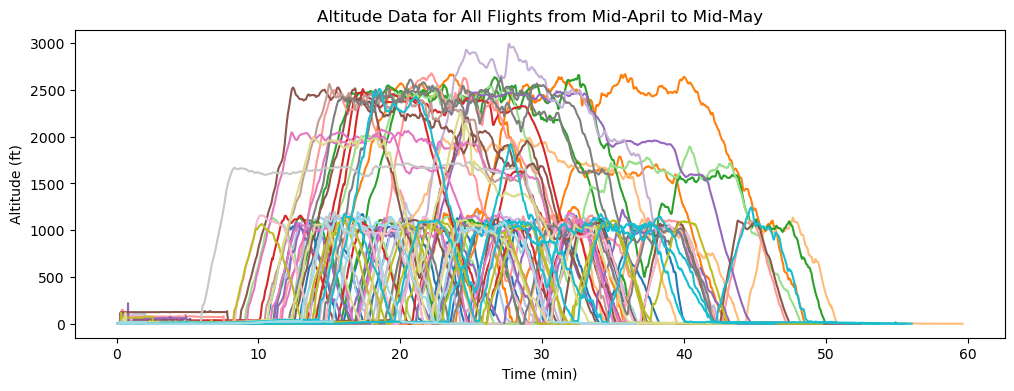

CPU times: total: 344 ms
Wall time: 528 ms


In [ ]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    plt.plot(df_power["time"][i], df_power["alt"][i],color=colormap(i / total_subfolders))
    #plt.plot(df_power["kw"][i])

plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude Data for All Flights from Mid-April to Mid-May')
plt.show()

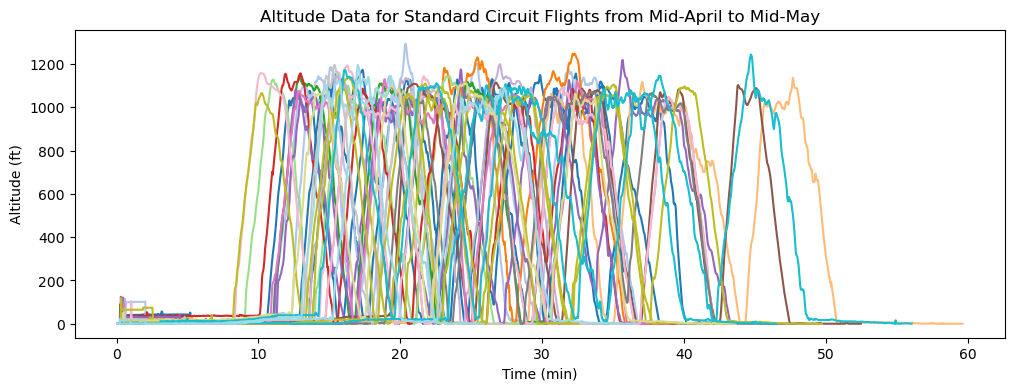

CPU times: total: 93.8 ms
Wall time: 413 ms


In [ ]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    if df_power["alt"][i].max() < 1400:
        plt.plot(df_power["time"][i], df_power["alt"][i],color=colormap(i / total_subfolders))


plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()

Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope: 615.3783946781864 ft/min
Plotting...


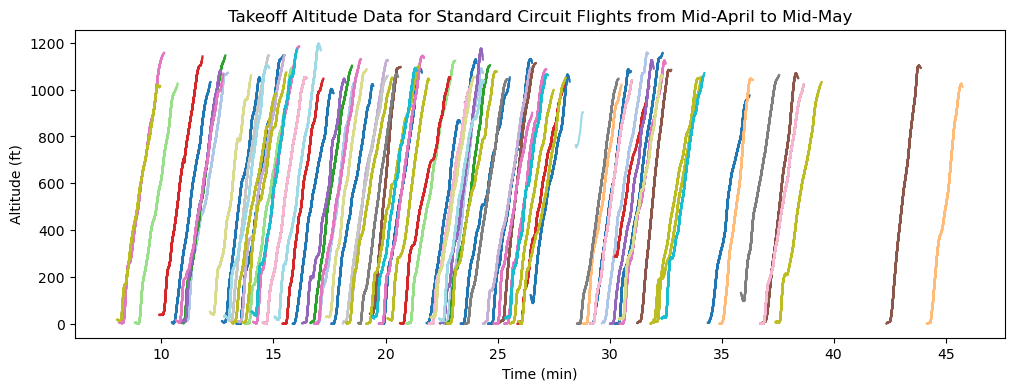

CPU times: total: 4.58 s
Wall time: 12.6 s


In [42]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
slopes = []
plt.figure(figsize=(12, 4))


for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1200:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
         # Filter out infinite and NaN values
        slope = slope.replace([np.inf, -np.inf], np.nan).dropna()

        # Store the slope values
        slopes.extend(slope[slope > 400].values)
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["alt"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')

average_slope = np.mean(slopes)
print(f"Average Slope: {average_slope} ft/min")

print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Takeoff Altitude Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Plotting...


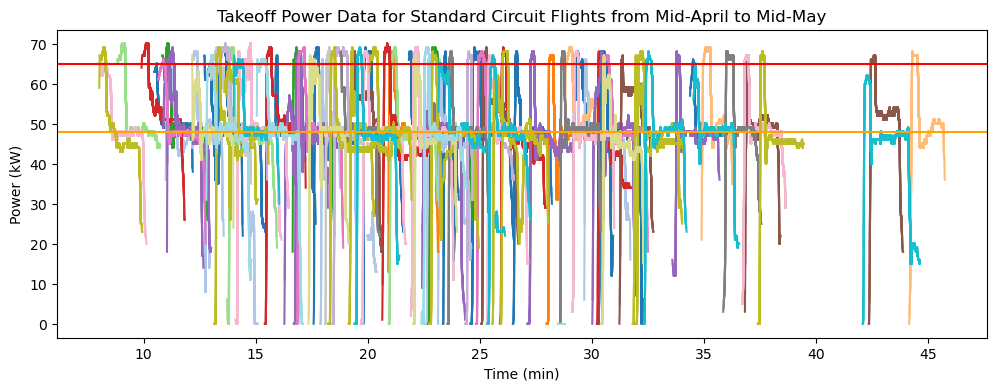

CPU times: total: 9.11 s
Wall time: 13.4 s


In [ ]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1200:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")

plt.axhline(y=65, color='r')
plt.axhline(y=48, color='orange')
plt.xlabel('Time (min)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Plotting...


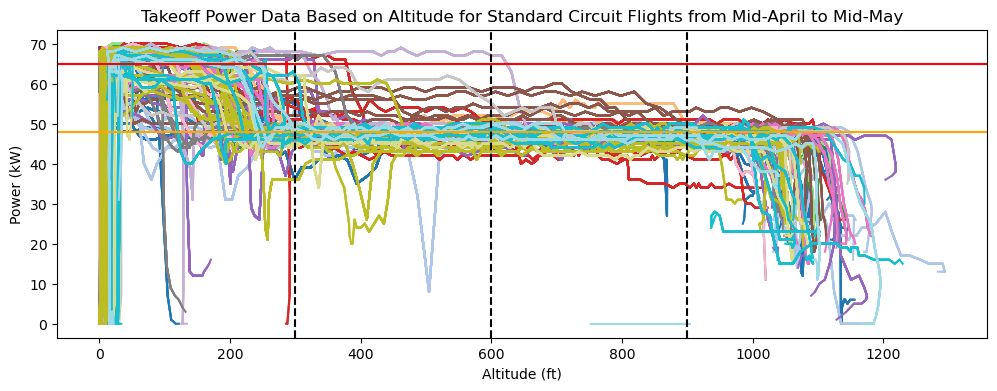

CPU times: total: 6.91 s
Wall time: 13.7 s


In [29]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1200:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["alt"][i][start_idx:end_idx]
                alt_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")

plt.axhline(y=65, color='r')
plt.axhline(y=48, color='orange')
plt.axvline(x=300, color='black', linestyle='--')
plt.axvline(x=600, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of SoC per Altitude: 1.1259122089965699%/300 ft
Plotting...


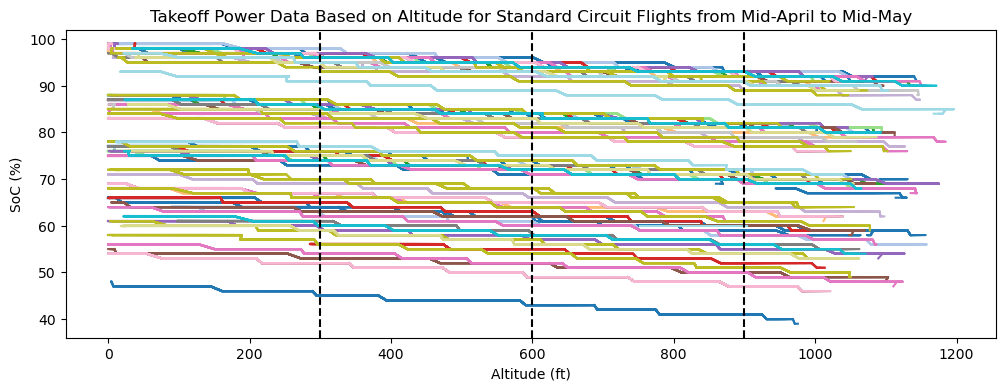

CPU times: total: 6.06 s
Wall time: 12.3 s


In [44]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []


for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1200:
        
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        soc_diff = df_power["soc"][i].diff()
        alt_diff2 = df_power["alt"][i].diff()
        slope_soc_per_alt = soc_diff / alt_diff
        valid_slopes = slope_soc_per_alt.replace([np.inf, -np.inf], np.nan).dropna().values
        slopes_soc_per_ft.extend(valid_slopes)
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["alt"][i][start_idx:end_idx]
                alt_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))


print('')
average_slope_soc_per_ft = abs(np.mean(slopes_soc_per_ft))*300
print(f"Average Slope of SoC per Altitude: {average_slope_soc_per_ft}%/300 ft")
print("Plotting...")
plt.axvline(x=300, color='black', linestyle='--')
plt.axvline(x=600, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Plotting...


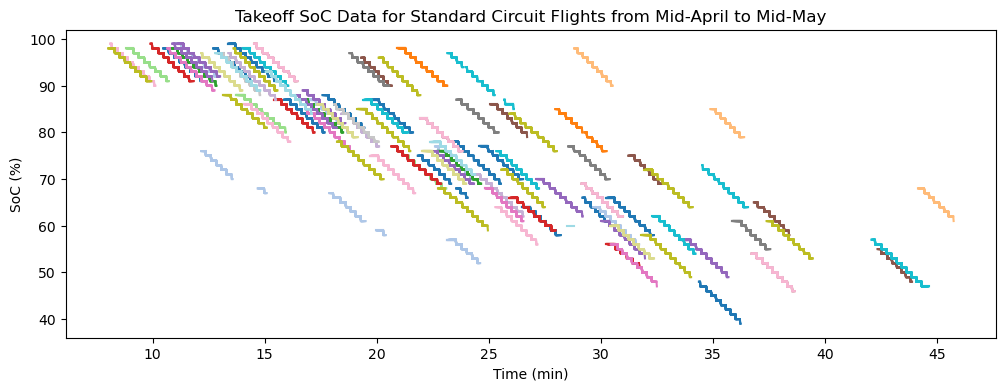

CPU times: total: 5.72 s
Wall time: 13.7 s


In [ ]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1200:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('SoC (%)')
plt.title('Takeoff SoC Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


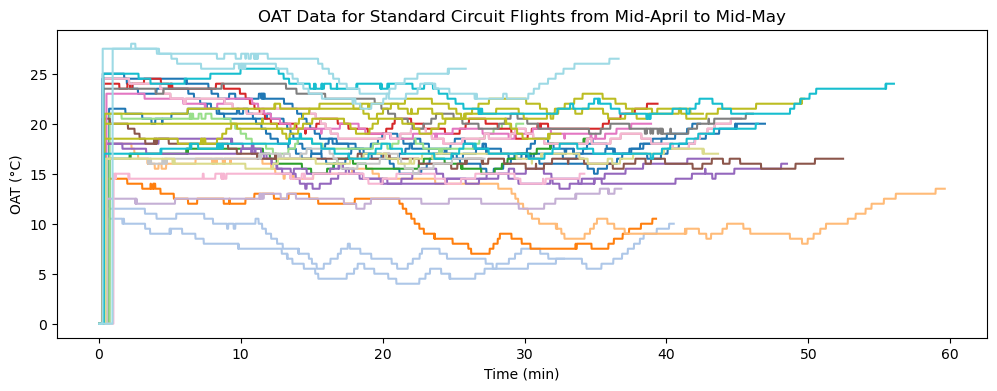

CPU times: total: 188 ms
Wall time: 357 ms


In [ ]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    if df_power["alt"][i].max() < 1200:
        first_non_zero = df_power["oat"][i].loc[df_power["oat"][i] != 0].iloc[0]
        df_power.loc[df_power["oat"][i] == 0, 'A'] = first_non_zero
        plt.plot(df_power["time"][i], df_power["oat"][i],color=colormap(i / total_subfolders))


plt.xlabel('Time (min)')
plt.ylabel('OAT (°C)')
plt.title('OAT Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()

Processing file data/waterloo/flight/csv-25795-6179 [100%]
Plotting...


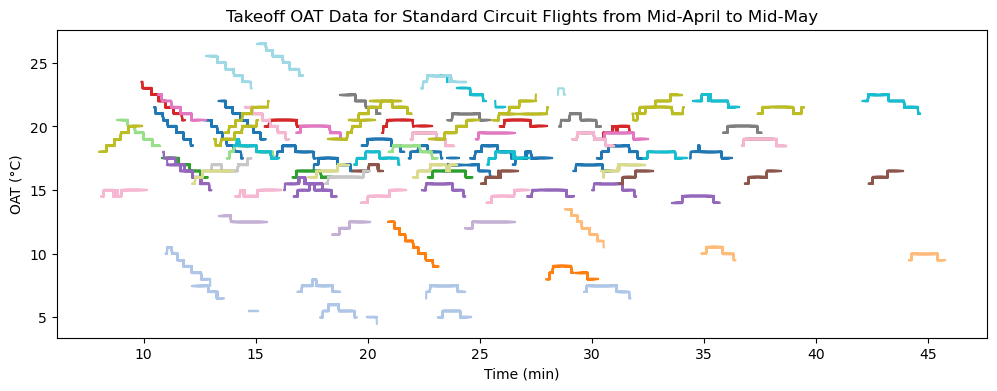

CPU times: total: 9.16 s
Wall time: 13.5 s


In [ ]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1200:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["oat"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('OAT (°C)')
plt.title('Takeoff OAT Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()
